In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import torch as tf
from torch.autograd.functional import jacobian
from functools import reduce
import itertools
import matplotlib.colors as mcolors

cuda0 = tf.device('cuda:0')
cpu0 = tf.device('cpu:0')

# Domain Transform filter

Here we provide a PyTorch implementation of the 2D Domain Transform filter from "Domain Transform for Edge-Aware Image and Video Processing" (Gastal and Oliveira)

In [2]:
def domain_transform_1d(idata, sigma_s, sigma_r, p=1):
    dx = np.diff(idata, axis=0)
    dx = np.pad(dx, ((1,0),(0,0)), "constant", constant_values=0)
    
    s_over_r = np.float64(sigma_s) / np.float64(sigma_r)
    one = np.float64(1)
    inv_p = one / p
    dx = ( one + (s_over_r * np.abs(dx))**p ) ** inv_p
    return dx
    
def RF_1d(idata, sigma_s, sigma_r, iterations=1, quality=2):

    h,w = np.shape(idata)
    odata   = np.copy(idata)
    sigma_H = sigma_s;
    
    for J in range(0,iterations):
        dx= domain_transform_1d(odata, sigma_s, sigma_r)

        for I in range(0, quality):
            sigma_H_i = sigma_H * np.sqrt(3) * 2**(quality - (I + 1)) / np.sqrt(4**quality - 1);
            a = np.exp(-np.sqrt(2) / sigma_H_i)

            # Forward-backward filter for the first dimension
            for i in range(1,h):
                odata[i,:] = odata[i,:] + np.power(a, dx[i,:]) * (odata[i-1,:] - odata[i,:])
            for i in range(h-2,0,-1):
                odata[i,:,] = odata[i,:] + np.power(a, dx[i+1,:]) * (odata[i+1,:] - odata[i,:])
    return odata

def domain_transform_2d(idata, sigma_s, sigma_r, p=1):
    dy = np.diff(idata, axis=0)
    dx = np.diff(idata, axis=1)

    dy = np.pad(dy, ((1,0),(0,0)), "constant", constant_values=0)
    dx = np.pad(dx, ((0,0),(1,0)), "constant", constant_values=0)
    
    s_over_r = np.float64(sigma_s) / np.float64(sigma_r)
    one = np.float64(1)
    inv_p = one / p
    dy = ( one + (s_over_r * np.abs(dy))**p ) ** inv_p
    dx = ( one + (s_over_r * np.abs(dx))**p ) ** inv_p
    
    return dy,dx

def RF_2d(idata, sigma_s, sigma_r, iterations=1, quality=2):

    h, w= np.shape(idata)
    odata   = np.copy(idata)
    sigma_H = sigma_s;
    
    for J in range(0,iterations):
        dy, dx = domain_transform_2d(odata, sigma_s, sigma_r)

        for I in range(0, quality):
            # Compute the required std. deviation of this iteration based on
            # the total number of iterations given in the parameter `quality`
            sigma_H_i = sigma_H * np.sqrt(3) * 2**(quality - (I + 1)) / np.sqrt(4**quality - 1);

            # Compute the feedback coefficient from the desired std. deviation
            a = np.exp(-np.sqrt(2) / sigma_H_i)

            # Forward-backward filter for the first dimension
            for i in range(1,h):
                odata[i,:] = odata[i,:] + np.power(a, dy[i,:]) * (odata[i-1,:] - odata[i,:])
            for i in range(h-2,0,-1):
                odata[i,:] = odata[i,:] + np.power(a, dy[i+1,:]) * (odata[i+1,:] - odata[i,:])

            # Forward-backward filter for the second dimension
            for j in range(1,w):
                odata[:,j] = odata[:,j] + np.power(a, dx[:,j]) * (odata[:,j-1] - odata[:,j])
            for j in range(w-2,0,-1):
                odata[:,j] = odata[:,j] + np.power(a, dx[:,j+1]) * (odata[:,j+1] - odata[:,j])
                
    return odata


# Generate Input

Generates the ground-truth material weight for the heat propagation

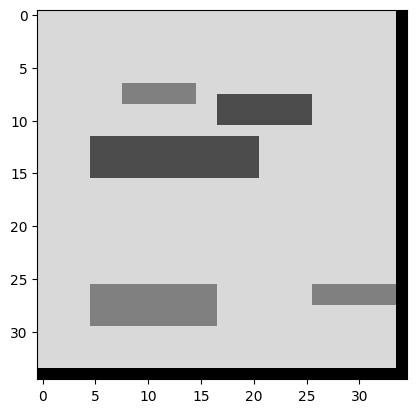

In [10]:
def zero_boundary(x):
    res = x*1
    res[-1,:]=0.00
    res[:,-1]=0.00

    return res

N = 35
plate = np.ones((N,N) , dtype= np.float32) * 0.85
for i in range(int(N/4),int(N/4)+3):
    for j in range(int(N/2),int(N-N/4)):
        plate[i,j]=0.3
        #plate[i,j]=0
        
for i in range(int(N/2.75),int(N/2.5)+2):
    for j in range(int(N/6),int(N-N/2.5)):
        plate[i,j]=0.3 #middle
        #plate[i,j]=0


for i in range(int(N/5),int(N/5)+2):
    for j in range(int(N/4),int(N/4 + N/5)):
        plate[i,j]=0.5 #upper left
        #plate[i,j]=0
        

for i in range(int(N - N/4),int(N -5)):
    for j in range(int(N/6),int(N/2)):
        plate[i,j]=0.5 #lower left
        #plate[i,j]=0
        

for i in range(int(3/4*N),int(3/4*N)+2):
    for j in range(int(3/4*N),N-1):
        plate[i,j]=0.5 #lower right
        #plate[i,j]=0

for i in range(N):
    for j in range(N):
        pass
        #plate[i,j] += 1*np.random.random()/6



plate = np.transpose(plate)
plate = zero_boundary(plate)

plt.imshow(np.transpose(plate),cmap='gray', vmin=0, vmax=1)

# Diffusion functions

In [4]:
def get_Dy(N):
    def generate_matrix(x):
        X = tf.reshape(x,(N,N))
        Y = X - tf.roll(X, shifts=1, dims=1)
        y = tf.flatten(Y)
        return y
       
    return jacobian(generate_matrix, tf.ones(N*N, device = cuda0))

def get_Dx(N):
    def generate_matrix(x):
        X = tf.reshape(x,(N,N))
        Y = X - tf.roll(X, shifts=1, dims=0)
        y = tf.flatten(Y)
        return y
       
    return jacobian(generate_matrix, tf.ones(N*N, device = cuda0))

Dy = get_Dy(N)
Dx = get_Dx(N)
Dxt = tf.transpose(Dx,0,1)
Dyt = tf.transpose(Dy,0,1)
DxD = tf.matmul(Dxt,Dx)
DyD = tf.matmul(Dyt,Dy)

Manually computing derivatives

$Y^{t+1}_{ij} = Y^t_{ij} + W_{i,j+1}\big( Y^{t}_{ij+1} - Y^{t}_{ij}  \big) + W_{i,j}\big( Y^{t}_{ij-1} - Y^{t}_{ij}  \big)$

\[\begin{matrix}
\frac{\partial Y^{t+1}_{ij}}{\partial W_{kl}} = \frac{\partial Y^{t}_{ij}}{\partial W_{kl}} + \delta_{i,j+1,k,l} \big( Y^{t}_{ij+1} - Y^{t}_{ij}  \big) +  W_{i,j+1} \big( \frac{\partial Y^{t}_{ij+1}}{\partial W_{kl}} - \frac{\partial Y^{t}_{ij}}{\partial W_{kl}}  \big)\\\ 
+  \delta_{i,j,k,l} \big( Y^{t}_{ij-1} - Y^{t}_{ij}  \big) +  W_{i,j} \big( \frac{\partial Y^{t}_{ij-1}}{\partial W_{kl}} - \frac{\partial Y^{t}_{ij}}{\partial W_{kl}}  \big)
\end{matrix}\]

In [5]:
def tf_flatdiag(M):
    return tf.diag(tf.flatten(M))

def tf_Nshift(M,N,s):
    M = tf.flatten(M)
    M = tf.reshape(M,(N*N*N,N))
    M = tf.roll(M, shifts=s, dims=1)
    M = tf.flatten(M)
    M = tf.reshape(M,(N*N, N*N))
    return M

def tf_Nshift2(M,N,s):
    M = tf.transpose(M,0,1)
    M = tf.flatten(M)
    M = tf.reshape(M,(N*N*N,N))
    M = tf.roll(M, shifts=s, dims=1)
    M = tf.flatten(M)
    M = tf.reshape(M,(N*N, N*N))
    M = tf.transpose(M,0,1)
    return M

#compute jacobian manually
def tf_diffusion_1d_manual(I,weights,T,N,l):
    def functional(x):
        J = tf.eye(N*N,device=cuda0)
        res = tf.tensor(I, device=cuda0)
        W = tf.reshape(x,(N,N))
        Id = tf.eye(N,device=cuda0)
        
        for t in range(T):
            prev = 1*res
            res = prev + l*tf.roll(W, shifts=1 ,dims=1)*(tf.roll(prev, shifts=1, dims=1) - prev) #fwd derivative
            res = res + l*W*(tf.roll(prev, shifts=-1, dims=1) - prev) #bwd derivative

            J0 = l*(tf.roll(prev, shifts=-1, dims=1) - prev) #bwd
            J0 = tf.diag(tf.flatten(J0))

            J1 = l*(tf.roll(prev, shifts=1, dims=1) - prev) #fwd
            J1 = tf.diag(tf.flatten(J1))
            J1 = tf_Nshift(J1,N,-1)

            J_new = J*(t>0) + J0 + J1

            #nonlinear terms
            J_new += l*tf.reshape(tf.flatten(tf.roll(W, shifts=1,dims=1)), (N*N,1))*(tf_Nshift2(J,N,1) - J)*(t>0) #fwd
            J_new += l*tf.reshape(tf.flatten(W), (N*N,1))*(tf_Nshift2(J,N,-1) - J)*(t>0)  #bwd

      
            J = J_new*1
            
        y = tf.flatten(res)
        return y, J
    x = tf.tensor(weights, device=cuda0)
    x = tf.flatten(x)
    return functional(x)

def tf_diffusion_1d(I,weights,T,N,l, jacob=True):

    def functional(x):
        res = tf.tensor(I, device=cuda0)
        W = tf.reshape(x,(N,N))
        for t in range(T):
            prev = 1*res
            res = prev + l*tf.roll(W, shifts=1 ,dims=1)*(tf.roll(prev, shifts=1, dims=1) - prev) #fwd
            res = res + l*W*(tf.roll(prev, shifts=-1, dims=1) - prev) #bwd
            
        y = tf.flatten(res)
        return y

    if jacob==False:
        x = tf.tensor(weights, device=cuda0)
        x = tf.flatten(x)
        F = functional(x)
        F = F.detach().cpu()
        return np.array(tf.reshape(F,(N,N)))

    return functional(weights), jacobian(functional,weights, strategy ="forward-mode", vectorize=True)

def tf_diffusion_2d(I,weights,T,N,l, jacob=True):

    def functional(x):
        res = tf.tensor(I, device=cuda0)
        W = tf.reshape(x,(N,N))
        for t in range(T):
            prev = 1*res
            res = prev + l*tf.roll(W, shifts=1 ,dims=1)*(tf.roll(prev, shifts=1, dims=1) - prev) #fwd
            res = res + l*W*(tf.roll(prev, shifts=-1, dims=1) - prev) #bwd

            res = res + l*tf.roll(W, shifts=1 ,dims=0)*(tf.roll(prev, shifts=1, dims=0) - prev) #up
            res = res + l*W*(tf.roll(prev, shifts=-1, dims=0) - prev)  #dwn
            
        y = tf.flatten(res)
        return y

    if jacob==False:
        x = tf.tensor(weights, device=cuda0)
        x = tf.flatten(x)
        F = functional(x)
        F = F.detach().cpu()
        return np.array(tf.reshape(F,(N,N)))
    
    return functional(weights), jacobian(functional,weights)


# Propagation Example

0.0001919269561767578
-2.4318695068359375e-05


Text(0.5, 1.0, '2d propagation')

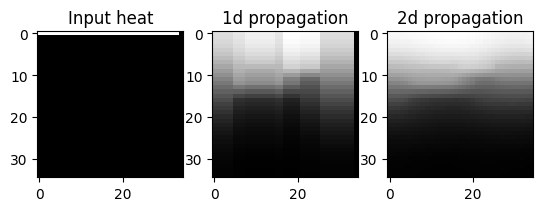

In [11]:
I = np.zeros((N,N), dtype = np.float32)
I[:,0]=100
I[-1,0] = 0

l = 0.25
T = 300

O1 = tf_diffusion_1d(I,plate,T,N,l, jacob= False)
O2 = tf_diffusion_2d(I,plate,T,N,l, jacob= False)

print(sum(sum(I)) - sum(sum(O1)))
print(sum(sum(I)) - sum(sum(O2)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(np.transpose(I),cmap='gray', vmin=0, vmax=np.max(I))
ax2.imshow(np.transpose(O1),cmap='gray', vmin=0, vmax=np.max(O1))
ax3.imshow(np.transpose(O2),cmap='gray', vmin=0, vmax=np.max(O2))

ax1.set_title("Input heat")
ax2.set_title("1d propagation")
ax3.set_title("2d propagation")

# ADMM method

The goal is to minimize

$E(W) = \|F(W) - O\|^2 + \mu\|\partial_x\,W\|^2 + \mu\|\partial_y\,W\|^2$

Consider splitting into

$E_1(W) =  \|F(W) - O\|^2 + \mu\|\partial_x\,W\|^2$

$E_2(W) =  \mu\|\partial_y\,W\|^2$

From which we obtain the Lagrangian

$L_{2\rho}(f,h,r) = E_1(f) + E_2(h) + r^T(f - h) + \rho\|{f-h}\|^2$

In [43]:
def tf_ADMM_method(I, N, T, O, Iter, mu, rho, x0, l, format = False, manual = True, Iter_f = 1, mode = 'homogeneous'): #input, output, and elapsed time T are known
    f = x0*1
    h = f*1
    r = f*0
    Id = tf.eye(N*N, device = cuda0)
    if mode=="homogeneous":
        mu_x = mu*1
        mu_y = mu*1

    elif mode =="edgeaware":
        mu_x = 0
        mu_y = 0
    
    for it in range(Iter):
        #minimize f
        for tt in range(Iter_f):
            if manual:
                F, J = tf_diffusion_1d_manual(I,f,T,N,l)
            else:
                F, J = tf_diffusion_1d(I,f,T,N,l)
            Jt = tf.transpose(J,0,1)
            
            lhs = tf.matmul(Jt,J) + rho*Id
            rhs = -tf.matmul(Jt, F - O - tf.matmul(J,f)) - r/2 + rho*h
            
            f = tf.linalg.solve(lhs,tf.reshape(rhs,(N*N,1)))
            f = tf.flatten(f)
            
                
        #minimize h
        if mode =='homogeneous':
            lhs = Id + mu_x*DxD/rho + mu_y*DyD
            rhs = f + r/(2*rho)
            h = tf.linalg.solve(lhs,tf.reshape(rhs,(N*N,1)))
            h = tf.flatten(h)
        elif mode =='edgeaware':
            color_dev = 0.1
            spatial_dev = np.sqrt((2*mu*(rho + 2*mu))/(rho*(rho+ 4*mu)))
            h2d = tf.reshape(f + r/(2*rho),(N,N))
            
            #apply DT filter
            idata = np.array(h2d.detach().cpu(), dtype = np.float32)
            idata = RF_2d(idata, spatial_dev, color_dev,iterations = 3, quality=3)
            h2d = tf.tensor(idata, device=cuda0)
    
            h = tf.flatten(h2d)

        #update r
        r = r + 2*rho*(f-h)
        
    if format:
        h =h.detach().cpu()
        return np.array(tf.reshape(h, (N,N)))
    return h

In [44]:
def misfit(I,x,T,N,l,Ot):
    F, J = tf_diffusion_1d_manual(I,x,T,N,l)
    err = tf.norm(F - Ot)**2
    return err


def apply_full_method(I, T, N, plate, mu, rho, O, l, inner_iter, outer_iter, iter_f, mode):
    #-----------------------------------------------------------------------
    #Prepare received signal------------------------------------------------
    #-----------------------------------------------------------------------
    Ot = tf.tensor(O, device = cuda0)
    Ot = tf.flatten(Ot)
    
    #-----------------------------------------------------------------------
    #Prepare starting iterations -------------------------------------------
    #-----------------------------------------------------------------------
    f = np.ones((N,N),dtype = np.float32)
    f = zero_boundary(f)
    f = tf.flatten(tf.tensor(f, device = cuda0))
    err = misfit(I,f,T,N,l,Ot)
    
    for t in range(outer_iter):
        new_f = tf_ADMM_method(I, N, T, Ot, inner_iter, mu, rho, f, l, Iter_f = iter_f, mode = mode)
        new_err = misfit(I,new_f,T,N,l,Ot)
        print("new = {}".format(new_err))
        if new_err <= err:
            f = new_f
            err = new_err
            rho = rho*0.90
            print("sucessful iteration")
        else:
            rho = rho*1.25
            print("backtracking")
   
    f = f.detach().cpu()
    f = np.array(tf.reshape(f, (N,N)))

    return f

# Experiments

In [75]:
#-----------------------------------------------------------------------
#Prepare input ---------------------------------------------------------
#-----------------------------------------------------------------------
I = np.zeros((N,N), np.float32)
I[:,0]=200
I[-1,0]=0

l = 0.25
T = 150
mu = 2
rho = 10

#-----------------------------------------------------------------------
#Prepare output --------------------------------------------------------
#-----------------------------------------------------------------------
O = tf_diffusion_2d(I,plate,T,N,l, jacob= False)
np.random.seed(0)
O += np.random.random((N,N))/4

#ADMM Parameters
inner_iter = 32
outer_iter = 1

f_tikhonov = apply_full_method(I, T, N, plate, mu, rho, O, l, inner_iter, outer_iter, 1, "homogeneous")
f_original = apply_full_method(I, T, N, plate, 0, rho, O, l , inner_iter, outer_iter, 1, "homogeneous")
f_domaintransform = apply_full_method(I, T, N, plate, mu, rho, O, l, inner_iter, outer_iter, 1, "edgeaware")

C:\Users\herme\AppData\Local\Temp\ipykernel_11652\3993616261.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = tf.tensor(weights, device=cuda0)


new = 2921.5908203125
sucessful iteration
new = 2644.546142578125
sucessful iteration
new = 2645.89990234375
sucessful iteration


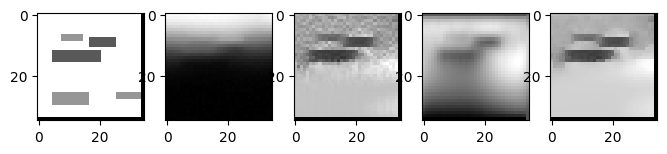

In [76]:
plt.rcParams['figure.figsize'] = (8, 5)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
ax1.imshow(np.transpose(plate),cmap='gray', vmin=0, vmax=np.max(plate))
ax2.imshow(np.transpose(O),cmap='gray', vmin=np.min(O), vmax=np.max(O))
ax3.imshow(np.transpose(f_original),cmap='gray', vmin=0, vmax=np.max(f_original))
ax4.imshow(np.transpose(f_tikhonov),cmap='gray', vmin=0, vmax=np.max(f_tikhonov))
ax5.imshow(np.transpose(f_domaintransform),cmap='gray', vmin=0, vmax=np.max(f_domaintransform))